In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import os
import pathlib
import base64
import gdown
from zipfile import ZipFile
import funkybob

DATA_PATH = "../data"
MODELS_PATH = "../models"

funky_name = iter(funkybob.RandomNameGenerator())  # to generate model names

print(f"TensorFlow v{tf.__version__}")
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow v2.9.0
GPUs available: 1


In [2]:
DATASET_PATH = f"{DATA_PATH}/CelebA"
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)

In [ ]:
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = f"{DATASET_PATH}/CelebA.zip"
gdown.download(url, output, quiet=False)

with ZipFile(output, "r") as zipobj:
    zipobj.extractall(f"{DATASET_PATH}")

In [3]:
dataset = keras.utils.image_dataset_from_directory(
    DATASET_PATH, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)
dataset = dataset.take(100)  # remove this

Found 202599 files belonging to 1 classes.
Metal device set to: Apple M1


2023-02-27 12:39:16.363214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-27 12:39:16.363349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


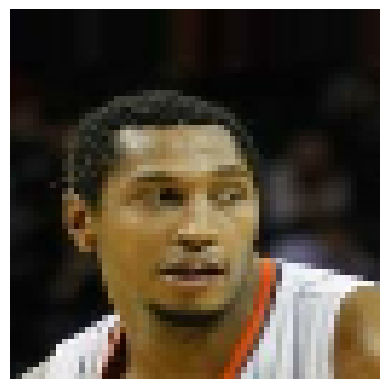

In [6]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [7]:
discriminator = keras.Sequential([
    keras.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
], name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [8]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
], name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [9]:
def random_id():
    return base64.urlsafe_b64encode(os.urandom(6)).decode()

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, name=random_id()):
        super().__init__()
        self.g_loss_metric = None
        self.d_loss_metric = None
        self.loss_fn = None
        self.g_optimizer = None
        self.d_optimizer = None
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self._name = name

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Convert noise to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat([
            tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))
        ], axis=0)

        # Add random noise to the labels -- important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (do NOT update weights of discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim, img_dir, num_img=3):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.file_writer = tf.summary.create_file_writer(img_dir)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        with self.file_writer.as_default():
            tf.summary.image("Generated Images", generated_images, step=epoch, max_outputs=self.num_img)

In [11]:
epochs = 10

# Model

model_name = next(funky_name)
print("Model:", model_name)

gan = GAN(
    name=model_name,
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim
)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Callbacks

log_dir = os.path.join("logs", model_name)

monitor = GANMonitor(
    img_dir=os.path.join(log_dir, "gen"),
    num_img=6, latent_dim=latent_dim
)

tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir)

model_checkpoint_path = os.path.join(MODELS_PATH, model_name)
pathlib.Path(model_checkpoint_path).mkdir(parents=True, exist_ok=True)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_path, model_name + ".{epoch:02d}.hdf5"),
    save_weights_only=True,
    save_best_only=False,
)

callbacks=[monitor, tensorboard, checkpoint]

# Training

gan.fit(dataset, epochs=epochs, callbacks=callbacks)

Model: gallant_ramanujan
Epoch 1/10


2023-02-27 12:39:53.297056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 148s 1s/step - d_loss: 0.4980 - g_loss: 1.3298
Epoch 2/10
100/100 [==============================] - 148s 1s/step - d_loss: 0.5024 - g_loss: 1.1698
Epoch 3/10
100/100 [==============================] - 148s 1s/step - d_loss: 0.5323 - g_loss: 1.2189
Epoch 4/10
100/100 [==============================] - 146s 1s/step - d_loss: 0.4763 - g_loss: 1.6104
Epoch 5/10
100/100 [==============================] - 146s 1s/step - d_loss: 0.4094 - g_loss: 1.7138
Epoch 6/10
100/100 [==============================] - 146s 1s/step - d_loss: 0.5959 - g_loss: 1.3261
Epoch 7/10
100/100 [==============================] - 146s 1s/step - d_loss: 0.5407 - g_loss: 1.2399
Epoch 8/10
100/100 [==============================] - 146s 1s/step - d_loss: 0.5470 - g_loss: 2.0721
Epoch 9/10
100/100 [==============================] - 145s 1s/step - d_loss: 0.4087 - g_loss: 2.2804
Epoch 10/10
100/100 [==============================] - 144s 1s/step - d_loss: 0.6349 - g_loss: 1.0942
